# Problem 1: GAN
## 1.1 Implement a Deep Convolutional GAN (DCGAN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,          # *** ONLY TRAIN SPLIT ***
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False
)

len(train_dataset)

60000

In [3]:
class Discriminator(nn.Module):
    def __init__(self, p_drop=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # 28x28x1 -> 14x14x64
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p_drop),

            # 14x14x64 -> 7x7x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p_drop),

            # 7x7x128 -> 4x4x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p_drop),

            # 4x4x256 -> 4x4x512
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p_drop),
        )

        self.classifier = nn.Linear(4 * 4 * 512, 1)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        return logits


In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, p_drop=0.2):
        super().__init__()
        self.noise_dim = noise_dim
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 256 * 7 * 7),
            nn.Dropout(p_drop),
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 256, 7, 7)
        img = self.net(x)
        return img


In [5]:
noise_dim = 100

G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

In [6]:
num_epochs = 20  # adjust as needed

for epoch in range(1, num_epochs + 1):
    G.train(); D.train()
    running_loss_D = 0.0
    running_loss_G = 0.0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        b = real_imgs.size(0)

        real_labels = torch.ones(b, 1, device=device)
        fake_labels = torch.zeros(b, 1, device=device)

        # ----- Train D -----
        optimizer_D.zero_grad()

        logits_real = D(real_imgs)
        loss_real = criterion(logits_real, real_labels)

        z = torch.randn(b, noise_dim, device=device)
        with torch.no_grad():
            fake_imgs = G(z)
        logits_fake = D(fake_imgs)
        loss_fake = criterion(logits_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ----- Train G -----
        optimizer_G.zero_grad()

        z = torch.randn(b, noise_dim, device=device)
        fake_imgs = G(z)
        logits_fake_for_G = D(fake_imgs)
        D_fake = torch.sigmoid(logits_fake_for_G)

        # ℓ_G = Ez[ log(1 - D(G(z))) ]
        loss_G = torch.log(1 - D_fake + 1e-8).mean()   # this will be ≤ 0
        loss_G.backward()
        optimizer_G.step()

        running_loss_D += loss_D.item() * b
        running_loss_G += loss_G.item() * b

    avg_loss_D = running_loss_D / len(train_dataset)
    avg_loss_G = running_loss_G / len(train_dataset)
    print(f"Epoch [{epoch}/{num_epochs}]  Loss_D: {avg_loss_D:.4f}  Loss_G: {avg_loss_G:.4f}")


Epoch [1/20]  Loss_D: 1.0388  Loss_G: -0.4796
Epoch [2/20]  Loss_D: 1.0796  Loss_G: -0.5082
Epoch [3/20]  Loss_D: 1.0864  Loss_G: -0.5235
Epoch [4/20]  Loss_D: 1.0785  Loss_G: -0.5201
Epoch [5/20]  Loss_D: 1.0815  Loss_G: -0.5186
Epoch [6/20]  Loss_D: 1.0971  Loss_G: -0.5261
Epoch [7/20]  Loss_D: 1.1109  Loss_G: -0.5323
Epoch [8/20]  Loss_D: 1.1197  Loss_G: -0.5293
Epoch [9/20]  Loss_D: 1.1293  Loss_G: -0.5401
Epoch [10/20]  Loss_D: 1.1301  Loss_G: -0.5535
Epoch [11/20]  Loss_D: 1.1537  Loss_G: -0.5482
Epoch [12/20]  Loss_D: 1.1554  Loss_G: -0.5704
Epoch [13/20]  Loss_D: 1.1587  Loss_G: -0.5594
Epoch [14/20]  Loss_D: 1.1599  Loss_G: -0.5623
Epoch [15/20]  Loss_D: 1.1702  Loss_G: -0.5565
Epoch [16/20]  Loss_D: 1.1727  Loss_G: -0.5595
Epoch [17/20]  Loss_D: 1.1757  Loss_G: -0.5752
Epoch [18/20]  Loss_D: 1.1619  Loss_G: -0.5565
Epoch [19/20]  Loss_D: 1.1707  Loss_G: -0.5609
Epoch [20/20]  Loss_D: 1.1639  Loss_G: -0.5649


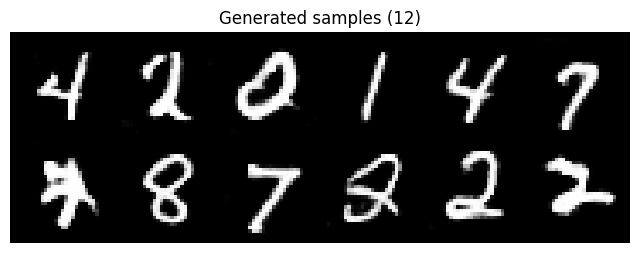

In [7]:
G.eval()
with torch.no_grad():
    z = torch.randn(12, noise_dim, device=device)
    gen_imgs = G(z).cpu()

# from [-1, 1] back to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0
gen_imgs = gen_imgs.clamp(0, 1)

grid = make_grid(gen_imgs, nrow=6, padding=2)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated samples (12)")
plt.show()

## 1.2 GAN as a pre-training framework

In [ ]:
class DiscriminatorFeatureExtractor(nn.Module):
    def __init__(self, discriminator):
        super().__init__()
        self.net = discriminator.net  # all conv / BN / dropout blocks

    def forward(self, x):
        x = self.net(x)
        return x.view(x.size(0), -1)  # flatten 4x4x512 -> 8192

feature_extractor = DiscriminatorFeatureExtractor(D).to(device)
feature_extractor.eval()

# freeze all its parameters (we don't train D anymore)
for p in feature_extractor.parameters():
    p.requires_grad = False

# infer feature dimension
example_batch, _ = next(iter(train_loader))
example_batch = example_batch.to(device)
with torch.no_grad():
    feat_example = feature_extractor(example_batch)
feature_dim = feat_example.shape[1]
print("Feature dimension:", feature_dim)


Feature dimension: 8192


In [9]:
from torch.utils.data import Subset

# 10% of training set
num_train = len(train_dataset)
subset_size = num_train // 10  # 6000 for MNIST
indices = torch.randperm(num_train)[:subset_size]
train_subset = Subset(train_dataset, indices)

subset_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False
)

# Test set
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False
)

len(train_subset), len(test_dataset)


(6000, 10000)

In [10]:
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, features):
        return self.fc(features)

classifier = LinearClassifier(feature_dim).to(device)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=1e-3)


In [ ]:
num_epochs_cls = 10  # classification epochs

for epoch in range(1, num_epochs_cls + 1):
    # ----- train -----
    classifier.train()
    feature_extractor.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in subset_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():          # only classifier is trained
            feats = feature_extractor(images)

        optimizer_cls.zero_grad()
        logits = classifier(feats)
        loss = criterion_cls(logits, labels)
        loss.backward()
        optimizer_cls.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100.0 * correct / total

    # ----- evaluate on test set -----
    classifier.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            feats = feature_extractor(images)
            logits = classifier(feats)
            _, predicted = logits.max(1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100.0 * test_correct / test_total

    print(f"[Epoch {epoch}/{num_epochs_cls}] "
          f"Train Loss: {train_loss:.4f}  "
          f"Train Acc: {train_acc:.2f}%  "
          f"Test Acc: {test_acc:.2f}%")


[Epoch 1/10] Train Loss: 0.2346  Train Acc: 93.15%  Test Acc: 97.43%
[Epoch 2/10] Train Loss: 0.0671  Train Acc: 97.88%  Test Acc: 97.76%
[Epoch 3/10] Train Loss: 0.0432  Train Acc: 98.63%  Test Acc: 97.92%
[Epoch 4/10] Train Loss: 0.0291  Train Acc: 99.08%  Test Acc: 97.82%
[Epoch 5/10] Train Loss: 0.0226  Train Acc: 99.40%  Test Acc: 97.90%
[Epoch 6/10] Train Loss: 0.0189  Train Acc: 99.55%  Test Acc: 97.92%
[Epoch 7/10] Train Loss: 0.0123  Train Acc: 99.77%  Test Acc: 98.22%
[Epoch 8/10] Train Loss: 0.0092  Train Acc: 99.92%  Test Acc: 98.20%
[Epoch 9/10] Train Loss: 0.0076  Train Acc: 99.95%  Test Acc: 98.19%
[Epoch 10/10] Train Loss: 0.0064  Train Acc: 99.93%  Test Acc: 98.17%


## 1.2 Answer:
After training the DCGAN in Part 1.1, I removed the final linear layer of the discriminator and used the remaining convolutional blocks as a fixed feature extractor. These layers were frozen, and I extracted features for 10% of the MNIST training set. On top of these features, I trained a single linear classifier to predict digit labels (0–9). The model was evaluated on the official MNIST test split.

**Results**
| Epoch | Train Acc  | Test Acc   |
| ----- | ---------- | ---------- |
| 1     | 93.15%     | 97.43%     |
| 5     | 99.40%     | 97.90%     |
| 10    | **99.93%** | **98.17%** |

**Discussion**
The classifier reached nearly 100% training accuracy and consistently achieved around 98% test accuracy. This performance is significantly higher than training a classifier from scratch using only 10% labeled data, indicating that the GAN discriminator learned meaningful visual features during adversarial training. These pretrained features enabled the linear classifier to generalize well despite limited supervision.

**Conclusion:**
GAN-based pretraining provides a strong feature representation that improves downstream classification performance when labeled data is scarce.
